# Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
tf.random.set_seed(42)

# Data

## Image path

In [2]:
train_dir = "./Data/Tomato/train"
test_dir = "./Data/Tomato/val"

In [3]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",
    input_shape=(112, 112, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
], name ="data_augmentation")

In [4]:
import tensorflow as tf

IMG_SIZE = (112, 112)
BATCH_SIZE = 32
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = train_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE,
    shuffle = True,
    seed=42
).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = test_dir,
    image_size = IMG_SIZE,
    label_mode = 'categorical',
    batch_size = BATCH_SIZE
)

class_names = test_data.class_names
valid_data = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

Found 10000 files belonging to 10 classes.
Found 984 files belonging to 10 classes.


## Augmented image view

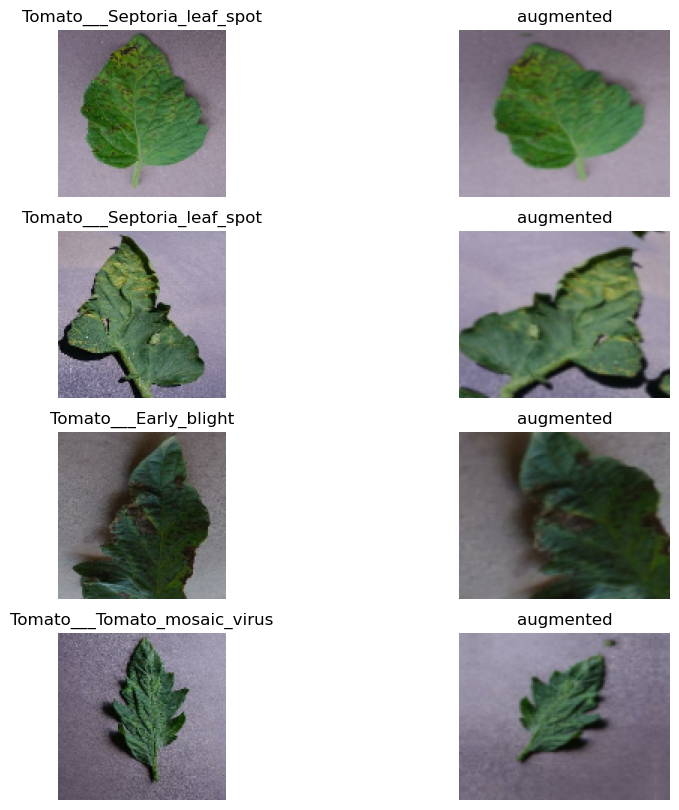

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    augmented_image_batch = data_augmentation(image_batch)
    image_plt_len = len(image_batch) if len(image_batch) < 4 else 4
    for i in range(0, image_plt_len):
        plt.subplot(image_plt_len,2,2*i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")
        plt.subplot(image_plt_len,2,2*i+2)
        plt.imshow(augmented_image_batch[i])
        plt.title(f"augmented")
        plt.axis("off")

In [8]:
checkpoint_path = "CheckPoint/cp.ckpt"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True
)

In [9]:
import tensorflow as tf

model = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(16, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(class_names), activation='softmax', name='output_layers')

])

## Summary

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 32)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 16)   0         
 2D)                                                             
                                                        

In [11]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [12]:
history = model.fit(
    train_data,
    epochs=100,
    steps_per_epoch=len(train_data),
    validation_data = test_data,
    validation_steps = len(test_data),
    callbacks = [
        checkpoint_callback
    ]
)

Epoch 1/100
313/313 [==============================] - 144s 436ms/step - loss: 2.1401 - accuracy: 0.1927 - val_loss: 1.9507 - val_accuracy: 0.3313
Epoch 2/100
313/313 [==============================] - 115s 366ms/step - loss: 1.7840 - accuracy: 0.3593 - val_loss: 1.8030 - val_accuracy: 0.3455
Epoch 3/100
313/313 [==============================] - 103s 330ms/step - loss: 1.5827 - accuracy: 0.4475 - val_loss: 1.5201 - val_accuracy: 0.4756
Epoch 4/100
313/313 [==============================] - 92s 294ms/step - loss: 1.4015 - accuracy: 0.5080 - val_loss: 1.3978 - val_accuracy: 0.4929
Epoch 5/100
313/313 [==============================] - 95s 303ms/step - loss: 1.2607 - accuracy: 0.5583 - val_loss: 1.3070 - val_accuracy: 0.5356
Epoch 6/100
313/313 [==============================] - 101s 322ms/step - loss: 1.1287 - accuracy: 0.6054 - val_loss: 1.2250 - val_accuracy: 0.5752
Epoch 7/100
313/313 [==============================] - 95s 304ms/step - loss: 1.0508 - accuracy: 0.6310 - val_loss: 1.08

In [13]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.figure(figsize=(12,6))
  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

## plot the model

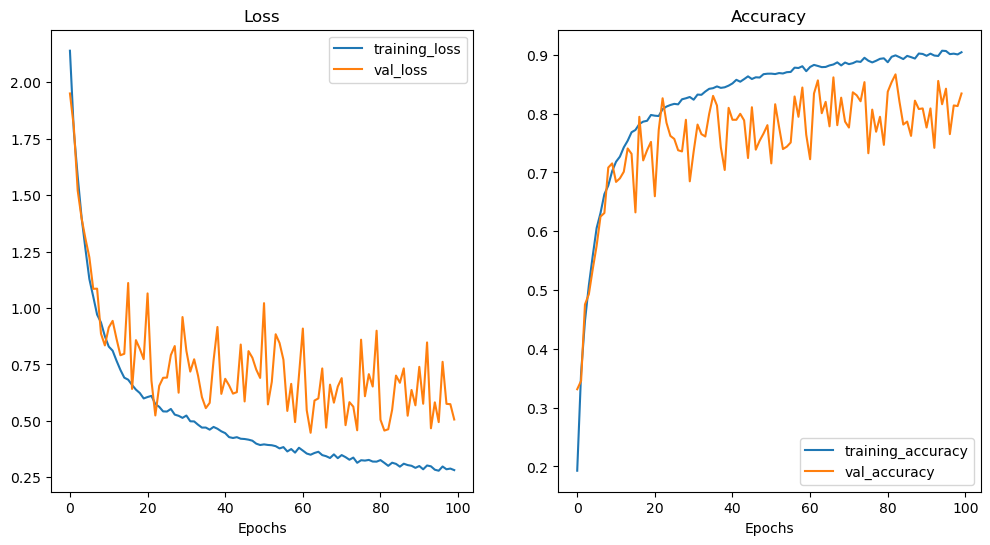

In [14]:
plot_loss_curves(history)

In [15]:
model.evaluate(test_data)

31/31 [==============================] - 1s 16ms/step - loss: 0.5060 - accuracy: 0.8343


[0.5060057640075684, 0.8343495726585388]

In [16]:
model.load_weights(checkpoint_path)

In [17]:
model.evaluate(train_data), model.evaluate(test_data)

31/31 [==============================] - 0s 11ms/step - loss: 0.4628 - accuracy: 0.8669


([0.38128983974456787, 0.8748000264167786],
 [0.4627785384654999, 0.8668699264526367])

In [18]:
! wget "https://github.com/HSAkash/Tomato-leaf-disease/raw/main/pretrain_model.h5"

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [19]:
load_model = tf.keras.models.load_model("pretrain_model.h5")

In [20]:
load_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, None, None, 32)    896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 32)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 16)   0         
 2D)                                                             
                                                        

In [21]:
load_model.evaluate(train_data),load_model.evaluate(test_data)

31/31 [==============================] - 0s 11ms/step - loss: 0.0759 - accuracy: 0.9827


([0.03175170347094536, 0.9904999732971191],
 [0.07585607469081879, 0.982723593711853])

1/1 [==============================] - 0s 211ms/step


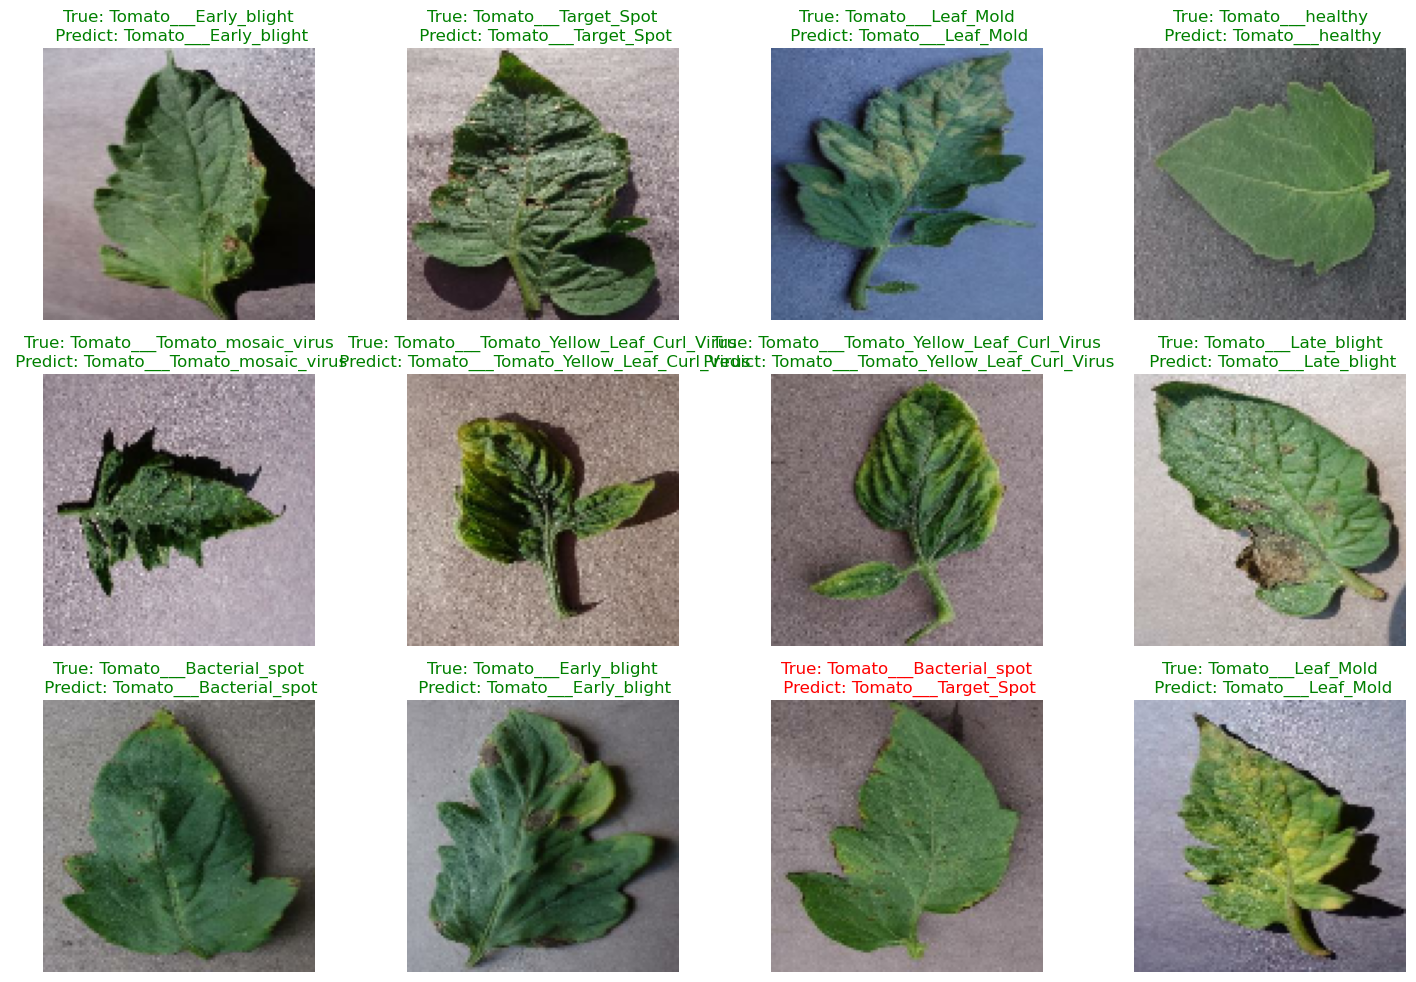

In [22]:
plt.figure(figsize=(18,12))
for image_batch,label_batch in test_data.take(1):
    predictions = load_model.predict(image_batch)
    predictions = np.argmax(predictions, axis=-1)
    for i in range(0,len(predictions) if len(predictions)<12 else 12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        true_class = class_names[np.argmax(label_batch[i])]
        predict_class = class_names[predictions[i]]
        title = f"""True: {true_class}\n Predict: {predict_class}"""
        plt.title(title, color='g' if true_class==predict_class else 'r')
        plt.axis("off")

In [23]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False): 
  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with
  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels,
         )
  
  # Make x-axis labels appear on bottom
  ax.tick_params(axis='x', labelrotation=90)
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)


## Predict y_pred and get y_true

In [24]:
y_true = np.array([])
y_pred = np.array([])
for x, y in test_data:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(load_model.predict(x), axis=-1)], axis=0)

1/1 [==============================] - 0s 98ms/step


## Plot confusion matrix

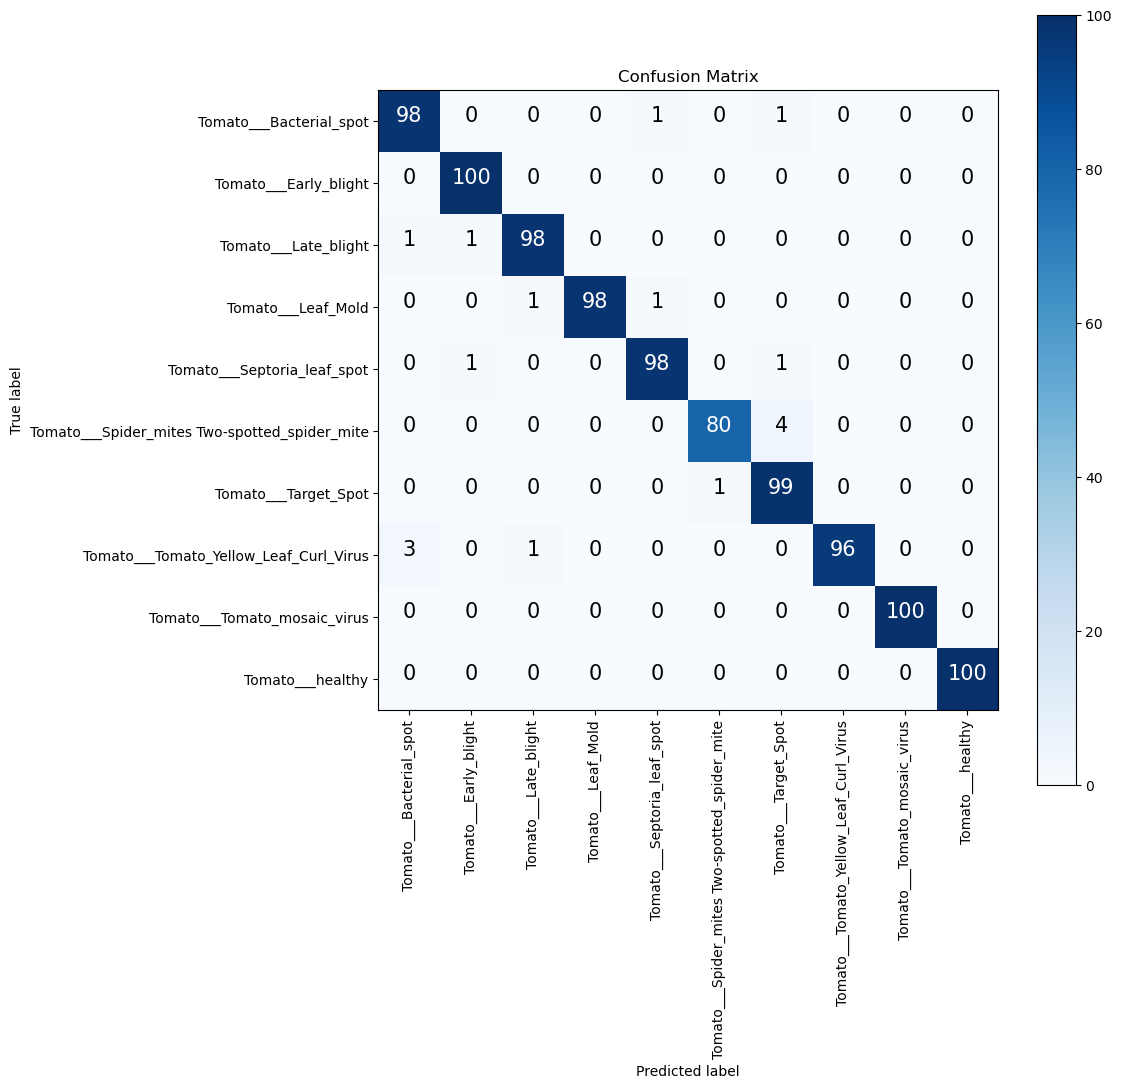

In [25]:
make_confusion_matrix(y_true, y_pred, class_names)

In [26]:
load_model.save('tomato_models2.h5')